In [ ]:
!pip install gdstk matplotlib
!pip install -U phidl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 534.2/534.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.9/157.9 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for phidl: filename=phidl-1.7.2-py3-none-any.whl size=100721 sha256=ab1c3ac45f6ad5eedc8315137a76149859a15bacc834d4f628532cd7c4be95e5
  Stored in directory: /root/.cache/pip/wheels/53/98/c6/a56fa2067a87220775fc37e23721a905ec39d5b8d8c05281f7
  Created wheel for gdspy: filename=gdspy-1.6.13-cp311-cp311-linux_x86_64.whl size=595437 sha256=e4a620708661a4fd41bd058f9430350f55dac3e3741ba638d69a0959704c146c
  Stored in directory: /root/.cache/pip/wheels/f0/7b/06/6515cfd23876a3b41fb7db9bba74e818f18f0db7f991d63e6d
Successfully built phidl gdspy


In [ ]:
from phidl import Device
from phidl import quickplot as qp # Rename "quickplot()" to the easier "qp()"
import phidl.geometry as pg
import phidl.routing as pr
import phidl.device_layout as pd

import os
import numpy as np

import gdstk
import matplotlib.pyplot as plt

import gdspy


layers_dict = {
        "via": (1, 0),
        "metal": (2, 0),
        "poly": (3, 0),
        "contact": (4, 0),
        "n+": (5, 0),
        "p+": (6, 0),
        "nwell": (7, 0)
    }


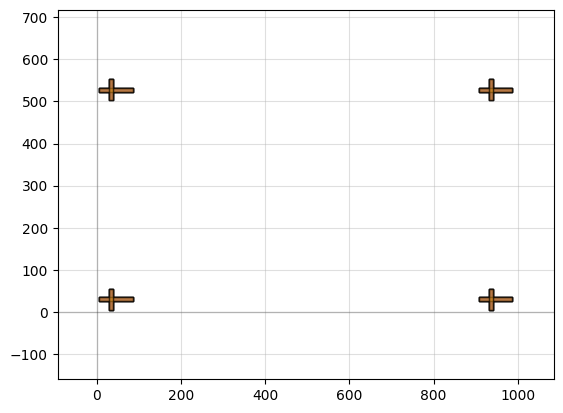

In [ ]:
def generate_template():
    """
    Generates a mask template with crosses at the four corners.
    """
    size=(992, 558)

    mask = Device()
    cross_width = 80
    cross_length = 50
    line_width = 10
    margin = 5

    # Define corner positions
    positions = [
        (margin, margin),  # Bottom-left
        (size[0]-cross_width-margin, margin),  # Bottom-right
        (margin, size[1]-cross_length-margin),  # Top-left
        (size[0]-cross_width-margin, size[1]-cross_length-margin)  # Top-right
    ]

    # Generate asymmetric crosses at each corner
    for x, y in positions:
      for i in range(6):
        horizontal = mask.add_ref(pg.rectangle(size=(cross_width, line_width),layer=(i, 0)))
        horizontal.move((x, y + (cross_length - line_width)/2))
        vert = mask.add_ref(pg.rectangle(size=(line_width, cross_length),layer=(i, 0)))
        vert.move((x + (cross_width-line_width)/3, y))

    return mask

mask = generate_template()
qp(mask)

In [ ]:
def add_mosfet(mask, channel_length = 10, channel_width = 80, diff= 50, position=(0,0), type = "NMOS"):

  gate_dimensions = (channel_length, channel_width + 10)
  diff_dimensions = (diff * 2 + channel_length, channel_width)
  pad_size = (24, 24)
  contact_size = 10 # CAN BE ADJUSTED

  diff_layer = "n+"
  if (type == "PMOS"):
    diff_layer = "p+"

  G = Device("gate")
  G_gate = G.add_ref(pg.rectangle(size = (gate_dimensions), layer = layers_dict["poly"]))
  G_gate.move(((2*contact_size-gate_dimensions[0])/2, 2*contact_size))
  G_via_p = G.add_ref(pg.rectangle(size = (2*contact_size, 2*contact_size), layer = layers_dict["poly"]))
  G_via_m = G.add_ref(pg.rectangle(size = (contact_size, contact_size), layer = layers_dict["via"]))
  G_via_m.move((contact_size/2, contact_size/2))
  G_contact = G.add_ref(pg.rectangle(size = pad_size, layer = layers_dict["metal"]))
  G_contact.move((contact_size-pad_size[0]/2, contact_size*1.75-pad_size[1]))

  D = Device("diffusion")
  D.diff = D.add_ref(pg.rectangle(size = (diff_dimensions[0], diff_dimensions[1]), layer = layers_dict[diff_layer]))
  via_y = (diff_dimensions[1] - contact_size) / 2
  contact_y = via_y - 2
  drain_width = diff_dimensions[0]/2 - gate_dimensions[0]/2
  D.contact_1 = D.add_ref(pg.rectangle(size = pad_size, layer = layers_dict["metal"]))
  D.contact_1.move(((drain_width-pad_size[0])/2, contact_y))
  D.contact_2 = D.add_ref(pg.rectangle(size = pad_size, layer = layers_dict["metal"]))
  D.contact_2.move((diff_dimensions[0]/2 + drain_width/2  + gate_dimensions[0]/2 - (pad_size[0]/2), contact_y))
  D.via_1 = D.add_ref(pg.rectangle(size = (contact_size, contact_size), layer = layers_dict["via"]))
  D.via_1.move(((drain_width-contact_size)/2 , via_y))
  D.via_2 = D.add_ref(pg.rectangle(size = (contact_size, contact_size), layer = layers_dict["via"]))
  D.via_2.move((diff_dimensions[0]/2 + drain_width/2  + gate_dimensions[0]/2 - (contact_size/2), via_y))

  MOSFET = Device()
  Gate = MOSFET.add_ref(G)
  Diffusion = MOSFET.add_ref(D)
  Diffusion.move(((contact_size * 2 -diff_dimensions[0])/2, contact_size * 2 + (gate_dimensions[1] - diff_dimensions[1])/2))

  mos = mask.add_ref(MOSFET)
  mos.move(position)
  return mos


In [ ]:
def add_rectangle(mask, width, length, position = (0,0), layer = "metal"):
  # mask is the current Device used for the mask
  # width is the width of the rectangle in um
  # length is the length of the rectangle in um
  # position is the coordinates of the bottom left corner of the rectangle in um
  # layer is the layer of the rectangle

  # returns the mask

  rect = mask.add_ref(pg.rectangle(size=(width,length),layer=layers_dict[layer]))
  rect.move(position)

  return rect

In [ ]:
def gds_to_png(gds_filename, output_prefix, dpi=300, layers = ["metal"], fill_color='black', bg_color='white'):
    # Load GDS file
    lib = gdspy.GdsLibrary(infile=gds_filename)

    # Define the unit count to be 80x45
    unit_width = 992
    unit_height = 558

    color1 = fill_color
    color2 = bg_color

    for layer_name in layers:
        layer = layers_dict[layer_name]
        # Create a matplotlib figure with 16:9 aspect ratio
        fig, ax = plt.subplots(figsize=(16, 9))
        if (layer == (3, 0)) :
          color1 = bg_color
          color2 = fill_color
        else:
          color1 = fill_color
          color2 = bg_color
        # Set background color
        fig.patch.set_facecolor(color2)
        ax.set_facecolor(color2)

        # Get all cells in the GDS file
        for cell in lib.top_level():
            polygons = cell.get_polygons(by_spec=True)
            if isinstance(polygons, dict):  # Older versions of gdspy
                for (lyr, datatype), polys in polygons.items():
                    if (lyr, datatype) == layer:
                        for poly in polys:
                            ax.fill(*zip(*poly), color=color1)
            elif isinstance(polygons, list):  # Newer versions return a list of tuples
                for poly, lyr, datatype in polygons:
                    if (lyr, datatype) == layer:
                        ax.fill(*zip(*poly), color=color1)

        # Set the limits to match the required unit count
        ax.set_xlim(0, unit_width)
        ax.set_ylim(0, unit_height)

        ax.set_aspect('equal')
        ax.axis('off')

        # Save the figure as a PNG with specified background
        png_filename = f"{output_prefix}_layer_{layer_name}.png"
        plt.savefig(png_filename, dpi=dpi, bbox_inches='tight', pad_inches=0, facecolor=color2)
        plt.close()

        print(f"Saved {png_filename}")


In [ ]:
def mask_to_png(mask, filename, layers = [(1,0)]):
  mask.write_gds(f"{filename}.gds")

  gds_to_png(f"{filename}.gds", f"{filename}_uv.jpg", fill_color = 'blue', bg_color='black', layers = layers)
  gds_to_png(f"{filename}.gds", f"{filename}_red.jpg", fill_color = 'red', bg_color='black', layers = layers)


In [ ]:
def add_resistor(mask, segments = 1, seg_width = 50, seg_length = 300, position = (0,0), separation = 30, contact_length = 50):
  # Generates resistor with parametrized number of segments and size of segments.

  resistor = Device()
  curr_pos = (0,0)
  top = 0
  for i in range(segments):
    top = not(top)
    if (i == 0):
      add_rectangle(resistor, seg_width, contact_length, curr_pos, layer = "metal")
    connect_y = curr_pos[1]
    if (top): connect_y = curr_pos[1] + (seg_length - seg_width)
    add_rectangle(resistor, seg_width, seg_length, curr_pos, layer = "n+")
    if (i != segments - 1):
      add_rectangle(resistor, separation + 5, seg_width, (curr_pos[0] + seg_width-2, connect_y), layer = "n+")
    else:
      if (top): connect_y = connect_y + (seg_width - contact_length)
      add_rectangle(resistor, seg_width, contact_length, (curr_pos[0], connect_y), layer = "metal")
    curr_pos = (curr_pos[0] + seg_width + separation, curr_pos[1])

  res = mask.add_ref(resistor)
  res.move(position)

  return res